# Image Classification - Search Space and HPO

:label:`sec_imgadvanced`


While the :ref:`sec_imgquick` introduced basic usage of AutoGluon `fit`, `evaluate`, `predict` with default configurations, this tutorial dives into the various options that you can specify for more advanced control over the fitting process.

These options include: defining the search space of various hyperparameter values regarding to the training of neural networks, specifying how to actually search through this hyperparameter space, and how to schedule each particular job which actually train a network under a particular hyperparameter configuration.
The advanced functionalities of AutoGluon allow you to leverage your external knowledge about your particular prediction problem and computing resources to guide the training process. If properly utilized, you may be able to achieve superior performance within less training time.


We again begin by letting AutoGluon know that `ImageClassification` is the task of interest:

In [1]:
import autogluon as ag
from autogluon import ImageClassification as task

## Create AutoGluon Dataset

Let's first create the dataset using the same subset of the `Shopee-IET` dataset as before.
Recall that as we only specify the `train_path`, a 90/10 train/validation split is automatically performed.

In [2]:
filename = ag.download('https://autogluon.s3.amazonaws.com/datasets/shopee-iet.zip')
ag.unzip(filename)

In [3]:
dataset = task.Dataset('data/train')

## Specify Which Networks to try

We start with specifying the pretrained neural network candidates.
Given such a list, AutoGluon will try training different networks from this list to identify the best-performing candidate.
This is an example of a :class:`autogluon.space.Categorical` search space, in which there are a limited number of values to choose from.

In [4]:
import gluoncv as gcv

@ag.func(
    multiplier=ag.Categorical(0.25, 1.0),
)
def get_mobilenet(multiplier):
    return gcv.model_zoo.MobileNetV2(multiplier=multiplier, classes=4)

net = ag.space.Categorical('resnet50_v1b', get_mobilenet())
print(net)

Categorical['resnet50_v1b', AutoGluonObject]


## Specify The Optimizer and Its Search Spaece

Similarly, we can manually specify the optimizer candidates.
We can construct another search space to identify which optimizer works best for our task (as well as what are the best hyperparameter configurations for this optimizer).
Additionally, we can customize the optimizer-specific hyperparameters search spaces, such as learning rate and weight decay using :class:`autogluon.space.Real`.

In [5]:
from mxnet import optimizer as optim

@ag.obj(
    learning_rate=ag.space.Real(1e-4, 1e-2, log=True),
    momentum=ag.space.Real(0.85, 0.95),
    wd=ag.space.Real(1e-6, 1e-2, log=True)
)
class NAG(optim.NAG):
    pass

optimizer = NAG()
print(optimizer)

AutoGluonObject -- NAG


## Search Algorithms

In AutoGluon, :meth:`autogluon.searcher` supports different search search_strategys for both hyperparameter optimization and architecture search.
Beyond simply specifying the space of hyperparameter configurations to search over, you can also tell AutoGluon what strategy it should employ to actually search through this space. 
This process of finding good hyperparameters from a given search space is commonly referred to as *hyperparameter optimization* (HPO) or *hyperparameter tuning*. 
:meth:`autogluon.scheduler` orchestrates how individual training jobs are scheduled.
We currently support random search, Hyperband and Bayesian Optimization. Although these are simple techniques, they can be surprisingly powerful when parallelized, which can be easily enabled in AutoGluon.

### Bayesian Optimization

Here is an example of using Bayesian Optimization using :class:`autogluon.searcher.SKoptSearcher`.

Bayesian Optimization fits a probabilistic *surrogate model* to estimate the function that relates each hyperparameter configuration to the resulting performance of a model trained under this hyperparameter configuration.

You can specify what kind of surrogate model to use (Gaussian Process, Random Forest, etc), as well as which acquisition function to employ (eg. Expected Improvement, Lower Confidence Bound, etc).  Below, we tell `fit` to perform Bayesian optimization using a Random Forest surrogate model with acquisitions based on Expected Improvement.
More detail in :class:`autogluon.searcher.SKoptSearcher`

In [6]:
time_limits = 2*60
epochs = 10

classifier = task.fit(dataset,
                      net=net,
                      optimizer=optimizer,
                      search_strategy='skopt', 
                      search_options={'base_estimator': 'RF', 'acq_func': 'EI'},
                      time_limits=time_limits,
                      epochs=epochs,
                      ngpus_per_trial=1)

print('Top-1 val acc: %.3f' % classifier.results[classifier.results['reward_attr']])





Top-1 val acc: 0.794


Load the test dataset and evaluate:

In [7]:
test_dataset = task.Dataset('data/test', train=False)

test_acc = classifier.evaluate(test_dataset)
print('Top-1 test acc: %.3f' % test_acc)


Top-1 test acc: 0.953


### Hyperband Early stopping

AutoGluon currently supports scheduling trials in serial order and with early stopping
(eg. if the performance of the model early within training already looks bad, the trial may be terminated early to free up resources).
Here is an example of using an early stopping scheduler :class:`autogluon.scheduler.HyperbandScheduler`:

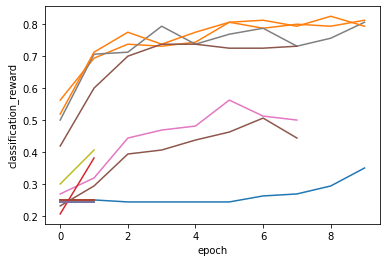

Top-1 val acc: 0.812


In [8]:
search_strategy = 'hyperband'

classifier = task.fit(dataset,
                      net=net,
                      optimizer=optimizer,
                      lr_scheduler=ag.space.Categorical('poly', 'cosine'),
                      search_strategy=search_strategy,
                      epochs=epochs,
                      num_trials=16,
                      verbose=False,
                      plot_results=True,
                      ngpus_per_trial=1,
                      grace_period=1)

print('Top-1 val acc: %.3f' % classifier.results[classifier.results['reward_attr']])

The test top-1 accuracy are:

In [9]:
test_acc = classifier.evaluate(test_dataset)
print('Top-1 test acc: %.3f' % test_acc)


Top-1 test acc: 0.891


Please see comparison of different search algorithms and scheduling strategies :ref:`course_alg`.
More options using fit is available at :class:`autogluon.task.ImageClassification`.

Finish and exit:

In [10]:
ag.done()